In [339]:
%matplotlib inline
import pandas
import numpy
import matplotlib.pyplot as plt
import seaborn

import sklearn
import sklearn.metrics
import sklearn.preprocessing
from sklearn.cross_decomposition import PLSRegression
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split


# Raw data

In [324]:
raw = pandas.read_csv('./KB_data.csv')
raw[:2]

,combined_shot_type,loc_x,loc_y,minutes_remaining,period,playoffs,season,seconds_remaining,shot_distance,shot_made_flag,shot_type,shot_zone_area,shot_zone_range,opponent,shot_id
0,Jump Shot,-157,0,10,1,0,2000-01,22,15,0.0,2PT Field Goal,Left Side(L),8-16 ft.,POR,2
1,Jump Shot,-101,135,7,1,0,2000-01,45,16,1.0,2PT Field Goal,Left Side Center(LC),16-24 ft.,POR,3


# Cleaning & Enriching

In [325]:
raw['shot_distance_squared'] = raw['shot_distance'] * raw['shot_distance']

# TODO: Remove rare super longshots. But only for training, exists in compete set
# raw = raw[raw['shot_distance'] < 30.0]

In [334]:
q, dist_quantiles_bins = pandas.qcut(raw['shot_distance'], q=10, duplicates='drop', retbins=True)
print('d', q.value_counts().sort_index())

def get_distance_class(group):
    distance = group['shot_distance']
    bins = dist_quantiles_bins
    distance_class = len(bins)
    for idx, edge in enumerate(bins[1:]):
        if distance < edge:
            distance_class = idx
            break
    #print('d', distance, distance_class)
    return distance_class
    #return pandas.Series([distance_class], index=['distance_class'])

raw['distance_class'] = raw.apply(get_distance_class, axis=1)
raw[:3]

d (-0.001, 2.0]    5613
(2.0, 7.0]       2240
(7.0, 12.0]      2930
(12.0, 15.0]     2652
(15.0, 17.0]     2390
(17.0, 19.0]     2326
(19.0, 23.0]     2728
(23.0, 25.0]     2894
(25.0, 79.0]     1924
Name: shot_distance, dtype: int64


,combined_shot_type,loc_x,loc_y,minutes_remaining,period,playoffs,season,seconds_remaining,shot_distance,shot_made_flag,shot_type,shot_zone_area,shot_zone_range,opponent,shot_id,shot_distance_squared,distance_class
0,Jump Shot,-157,0,10,1,0,2000-01,22,15,0.0,2PT Field Goal,Left Side(L),8-16 ft.,POR,2,225,4
1,Jump Shot,-101,135,7,1,0,2000-01,45,16,1.0,2PT Field Goal,Left Side Center(LC),16-24 ft.,POR,3,256,4
2,Jump Shot,138,175,6,1,0,2000-01,52,22,NaN,2PT Field Goal,Right Side Center(RC),16-24 ft.,POR,4,484,6


# Splitting test data

In [436]:
use_rows = raw['shot_made_flag'].notnull()
usage_set = raw[use_rows]
compete_set = raw[pandas.isna(raw['shot_made_flag'])]

# FIXME: test with different test/train splits
seed = 2
test_size = 0.3
training, testing = train_test_split(usage_set, test_size=test_size, random_state=seed)

assert compete_set['shot_id'].shape[0] == 5000, compete_set.shape
assert compete_set['shot_id'].values[0] == 4
assert compete_set['shot_id'].values[-1] == 30693

training[:2]

,combined_shot_type,loc_x,loc_y,minutes_remaining,period,playoffs,season,seconds_remaining,shot_distance,shot_made_flag,shot_type,shot_zone_area,shot_zone_range,opponent,shot_id,shot_distance_squared,distance_class
15517,Jump Shot,17,127,7,3,0,2011-12,46,12,1.0,2PT Field Goal,Center(C),8-16 ft.,IND,18506,144,3
16085,Layup,-24,12,0,2,0,2011-12,0,2,0.0,2PT Field Goal,Center(C),Less Than 8 ft.,HOU,19154,4,1


# Data / feature exploration

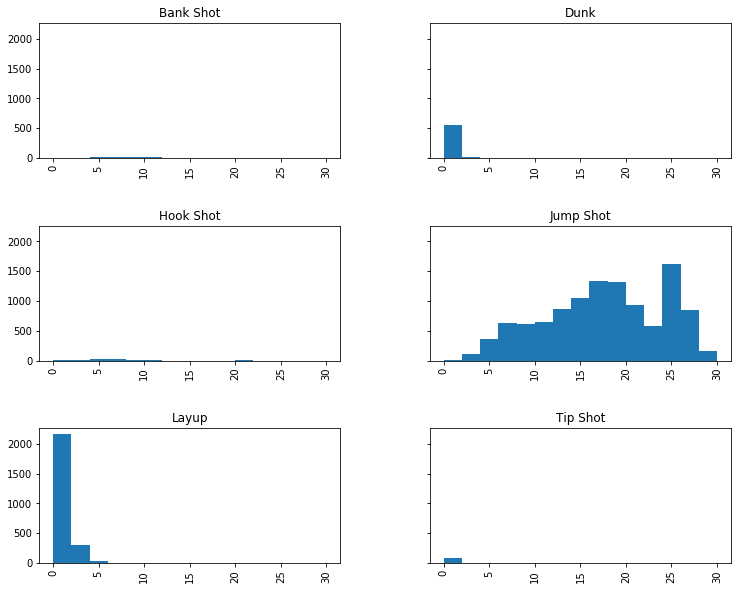

In [167]:
training.hist(column='shot_distance', by='combined_shot_type',
              bins=15, range=(0.0, 30.0), figsize=(12,10), sharey=True
);

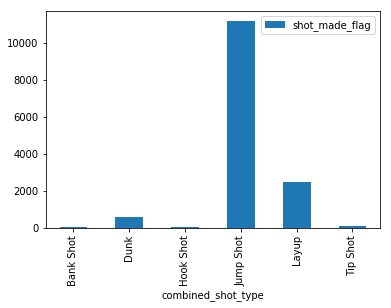

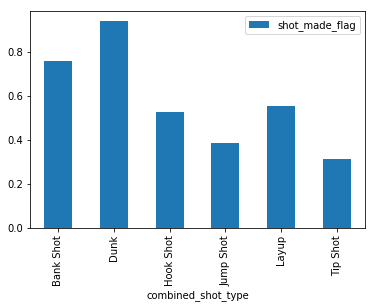

In [169]:
training.groupby(['combined_shot_type']).agg({'shot_made_flag': 'count'}).plot(kind='bar')
training.groupby(['combined_shot_type']).agg({'shot_made_flag': 'mean'}).plot(kind='bar')

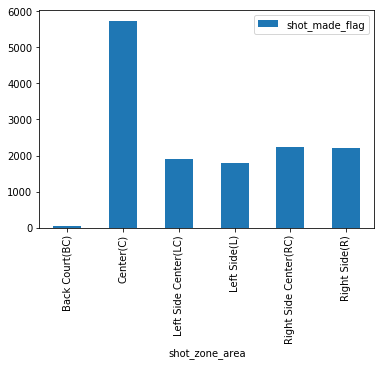

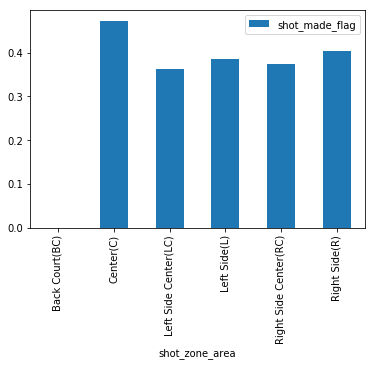

In [173]:
shot_zone = training[training['combined_shot_type'] != 'Dunk'].groupby(['shot_zone_area'])
shot_zone.agg({'shot_made_flag': 'count'}).plot(kind='bar')
shot_zone.agg({'shot_made_flag': 'mean'}).plot(kind='bar')

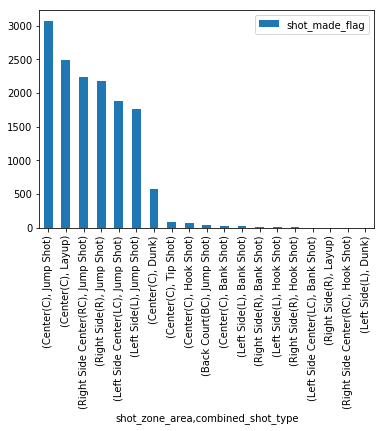

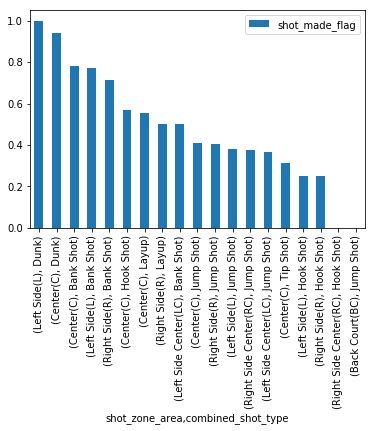

In [52]:
shot_area_type = training.groupby(['shot_zone_area', 'combined_shot_type'])
shot_area_type.agg({'shot_made_flag': 'count'}).sort_values(by='shot_made_flag', ascending=False).plot(kind='bar')
shot_area_type.agg({'shot_made_flag': 'mean'}).sort_values(by='shot_made_flag', ascending=False).plot(kind='bar')

In [174]:
training['season'].unique()

array(['2004-05', '1997-98', '2006-07', '2012-13', '2003-04', '2005-06',
       '2000-01', '2009-10', '2002-03', '2007-08', '2015-16', '2010-11',
       '1998-99', '2001-02', '1999-00', '2013-14', '2008-09', '2011-12',
       '1996-97', '2014-15'], dtype=object)

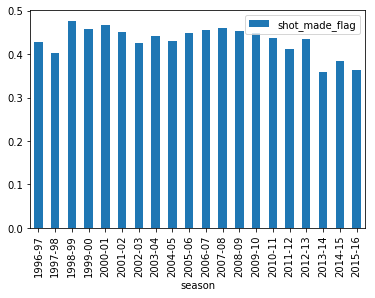

In [175]:
training.groupby(['season']).agg({'shot_made_flag': 'mean'}).plot(kind='bar')

In [11]:
training['opponent'].unique()

array(['DET', 'DAL', 'HOU', 'LAC', 'SAC', 'CHA', 'GSW', 'UTA', 'MIL',
       'IND', 'POR', 'NYK', 'NOH', 'VAN', 'NOP', 'MEM', 'OKC', 'MIN',
       'ORL', 'NJN', 'DEN', 'CLE', 'MIA', 'SEA', 'CHI', 'SAS', 'BOS',
       'PHX', 'WAS', 'TOR', 'PHI', 'ATL', 'BKN'], dtype=object)

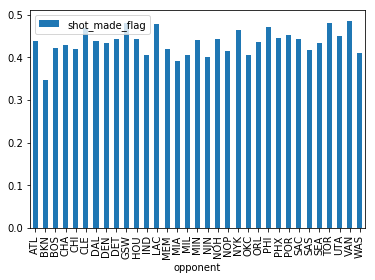

In [30]:
training.groupby(['opponent']).agg({'shot_made_flag': 'mean'}).plot(kind='bar')

In [ ]:
# BKN is an outlier, very few matches

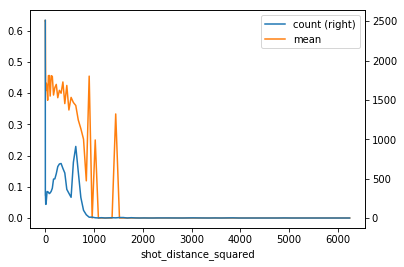

In [202]:
type_by_distance = training[training['combined_shot_type'] != '2Jump Shot'].groupby(['shot_distance_squared'])
count = type_by_distance.agg({'shot_made_flag': 'count'})
mean = type_by_distance.agg({'shot_made_flag': 'mean'})
df = pandas.DataFrame({'count': count['shot_made_flag'], 'mean': mean['shot_made_flag']}, index=count.index)
df.plot(secondary_y='count')

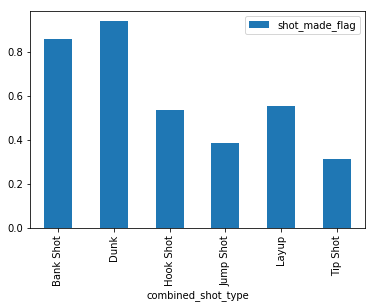

In [95]:
training[training['shot_distance'] < 5.0].groupby(['combined_shot_type']).agg({'shot_made_flag': 'mean'}).plot(kind='bar')

d [ 0.  2.  7. 12. 15. 17. 19. 23. 25. 79.]
e 0 2.0
e 10 2.0
e 10 7.0
e 10 12.0
e 26 2.0
e 26 7.0
e 26 12.0
e 26 15.0
e 26 17.0
e 26 19.0
e 26 23.0
e 26 25.0
e 26 79.0
e 26 2.0
e 26 7.0
e 26 12.0
e 26 15.0
e 26 17.0
e 26 19.0
e 26 23.0
e 26 25.0
e 26 79.0
e 0 2.0
e 0 2.0
e 25 2.0
e 25 7.0
e 25 12.0
e 25 15.0
e 25 17.0
e 25 19.0
e 25 23.0
e 25 25.0
e 25 79.0
e 3 2.0
e 3 7.0
e 17 2.0
e 17 7.0
e 17 12.0
e 17 15.0
e 17 17.0
e 17 19.0
e 0 2.0


,shot_distance,distance_class
5862,0,0
20287,10,2
9367,26,8
16878,26,8
4486,0,0
9591,0,0
7325,25,8
9019,3,1
688,17,5
13191,0,0


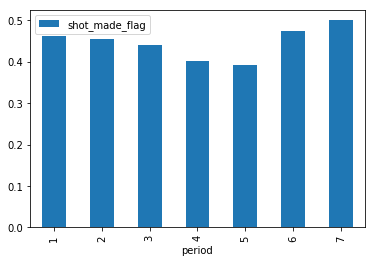

In [251]:
training.groupby(['period']).agg({'shot_made_flag': 'mean'}).plot(kind='bar')

# Model

In [332]:
training[training['distance_class'] < 0.0]

,combined_shot_type,loc_x,loc_y,minutes_remaining,period,playoffs,season,seconds_remaining,shot_distance,shot_made_flag,shot_type,shot_zone_area,shot_zone_range,opponent,shot_id,shot_distance_squared,distance_class
24376,Jump Shot,36,791,0,1,1,2009-10,0,79,0.0,3PT Field Goal,Back Court(BC),Back Court Shot,OKC,29123,6241,-1


In [ ]:

# TODO: setup grid search, testing with multiple splits
# TODO: find a way to visualize wrong/correctly classified shots. Maybe try PCA

inputencoder = sklearn.preprocessing.OneHotEncoder(n_values=11)
shotencoder = sklearn.preprocessing.LabelBinarizer()
seasonencoder = sklearn.preprocessing.LabelBinarizer()

#features = ['distance_class', 'combined_shot_type']

def input_vector(data):
    t = shotencoder.fit_transform(data[['combined_shot_type']])
    dc = inputencoder.fit_transform(data[['distance_class']]).todense().astype(int)
    se = seasonencoder.fit_transform(data[['season']])
    d = data[['shot_distance']]
    p = data[['period']]
    m = data[['minutes_remaining']]
    sec = data[['seconds_remaining']]
    C = numpy.concatenate([ d, t, m ], axis=1)
    return C

Y = training['shot_made_flag']

model = LinearSVC(C=0.7)
X_train = input_vector(training)
model.fit(X_train, Y)

X_test = input_vector(testing)
Y_test = testing['shot_made_flag'].astype(numpy.bool)
Y_pred = model.predict(X_test)

# classification accuracy
tr = sklearn.metrics.accuracy_score(Y, model.predict(X_train)) 
te = sklearn.metrics.accuracy_score(Y_test, Y_pred)
tr, te

In [459]:
Y_comp = model.predict(input_vector(compete_set))

out = compete_set.copy()
out['shot_made_flag'] = Y_comp.astype(numpy.float)
out.to_csv('./submission.csv', index=False, columns=['shot_id', 'shot_made_flag'])

### Features

* Shot distance
* Shot type. Categorical
* Location on court. How is organized?
* Points
* Opponent
* Minutes/seconds remaining. In the period? (4x12 min)
* Period
* Season


### Target

Where predictions are removed (nAn) is the validation data

Is there any pattern here that can be exploited?


## Modelling

TRY? a dimenson reduction technique to get a feel for the data. PCA/PSLR

TODO

* check existing Kaggle competitions, good performing algorithms
* setup sklearn pipeline
* setup Grid search
* format Kaggle submission

Trips & tricks

* LabelEncoder. Categoical data. Ordinal (orderable) versus nominal (not orderable)
